In [1]:
import numpy as np     #只需要下载numpy库即可
import random
import GridWorld_v3
from draw import draw  #绘图函数
from ExperienceReplayBuffer import ExperienceReplayBuffer
import tqdm

In [2]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v3.GridWorld_v3(forbiddenAreaScore=-10, score=1,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
gridworld.show()
trajectorySteps = 1000

⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


In [3]:
state_values = np.array([random.random() for i in range(25)])
learning_rate = 0.01
gamma = 0.99

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(2,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,5)  #拟合的Action value，5个输出
    def forward(self, state):
        h1 = self.fc1(state)
        h1 = F.relu(h1)
        h2 = self.fc2(h1)
        h2 = F.relu(h2)
        Q = self.fc3(h2)
        return Q
        

In [5]:
experiencePool = ExperienceReplayBuffer(max_size=10000)
policy = 0.2 * np.ones((rows*columns,5))
episodes = [gridworld.getTrajectoryScore(nowState = 10,action = random.randint(0,4),policy = policy) 
            for i in range(500)]
for trajectory in episodes:
    for exp in trajectory:
        experiencePool.add_expericence(exp)

In [6]:
lr = 0.0015
network = model()
optimizer = optim.Adam(network.parameters(), lr = lr)
batch_size = 100

In [7]:
batch_size = 10
batch = experiencePool.sample_batch(batch_size=batch_size)
tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

tmpstate = tmpstate.reshape(batch_size,1)
tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  #将state变成了行列
nextState = nextState.reshape(batch_size,1)
nextState = np.hstack((nextState // 5, nextState % 5))  #将state变成了行列

tmpstate = torch.tensor(tmpstate,dtype = torch.float32).view(batch_size,2)
nextState = torch.tensor(nextState,dtype = torch.float32).view(batch_size,2)

# tmpaction = torch.tensor(tmpaction,dtype = torch.int).view(batch_size,1)
# nextAction = torch.tensor(nextAction,dtype = torch.int).view(batch_size,1)

tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)
terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)

In [8]:
# 以下一个state出发，计算下一个state的五个action values
next_action_values = network(nextState)  #网络

b = [next_action_values[i,nextAction[i]] for i in range(batch_size)]
next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1)

# c = next_action_values.max(1)[0] #改成DQN了，这里就得取最大值
# next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)

target = tmpscore + (1.0 - terminal) * gamma * next_action_value

In [9]:
next_action_values

tensor([[-0.2462,  0.2107,  0.2057,  0.1329,  0.2204],
        [-0.3260,  0.2834,  0.2649,  0.2378,  0.3254],
        [-0.1657,  0.1806,  0.2355,  0.2127,  0.0619],
        [-0.1936,  0.1733,  0.1480,  0.1028,  0.1336],
        [-0.3409,  0.3622,  0.1845,  0.2100,  0.1626],
        [-0.3580,  0.3409,  0.2711,  0.3030,  0.3657],
        [-0.2462,  0.2107,  0.2057,  0.1329,  0.2204],
        [-0.1936,  0.1733,  0.1480,  0.1028,  0.1336],
        [-0.2236,  0.2385,  0.1759,  0.1842,  0.1448],
        [-0.1936,  0.1733,  0.1480,  0.1028,  0.1336]],
       grad_fn=<AddmmBackward0>)

In [10]:
b

[tensor(0.1329, grad_fn=<SelectBackward0>),
 tensor(0.2649, grad_fn=<SelectBackward0>),
 tensor(-0.1657, grad_fn=<SelectBackward0>),
 tensor(-0.1936, grad_fn=<SelectBackward0>),
 tensor(0.1626, grad_fn=<SelectBackward0>),
 tensor(0.2711, grad_fn=<SelectBackward0>),
 tensor(0.2057, grad_fn=<SelectBackward0>),
 tensor(0.1028, grad_fn=<SelectBackward0>),
 tensor(0.1759, grad_fn=<SelectBackward0>),
 tensor(0.1480, grad_fn=<SelectBackward0>)]

In [11]:
next_action_value

tensor([[ 0.1329],
        [ 0.2649],
        [-0.1657],
        [-0.1936],
        [ 0.1626],
        [ 0.2711],
        [ 0.2057],
        [ 0.1028],
        [ 0.1759],
        [ 0.1480]])

In [12]:
# 通过神经网络计算当前状态对应的动作价值
now_action_values = network(tmpstate)    #网络

# 提取批次中第一个样本的动作价值
now_action_value = now_action_values[0,tmpaction[0]]

# 遍历批次中剩余的样本，将每个样本对应的动作价值拼接起来
for i in range(1,batch_size):
    # 将当前的动作价值和新样本的动作价值在第0维上拼接
    now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)

# 调整动作价值张量的形状，使其成为一个二维张量，每行一个动作价值
now_action_value = now_action_value.view(-1,1)

In [13]:
tmpaction

array([1, 1, 2, 4, 0, 0, 0, 3, 1, 1])

In [14]:
now_action_values

tensor([[-0.1936,  0.1733,  0.1480,  0.1028,  0.1336],
        [-0.2840,  0.2633,  0.2060,  0.1936,  0.2375],
        [-0.1288,  0.1052,  0.1568,  0.0964,  0.0098],
        [-0.1936,  0.1733,  0.1480,  0.1028,  0.1336],
        [-0.3409,  0.3622,  0.1845,  0.2100,  0.1626],
        [-0.3773,  0.3996,  0.2999,  0.4108,  0.4084],
        [-0.2840,  0.2633,  0.2060,  0.1936,  0.2375],
        [-0.2462,  0.2107,  0.2057,  0.1329,  0.2204],
        [-0.1657,  0.1806,  0.2355,  0.2127,  0.0619],
        [-0.1288,  0.1052,  0.1568,  0.0964,  0.0098]],
       grad_fn=<AddmmBackward0>)

In [15]:
now_action_value

tensor([[ 0.1733],
        [ 0.2633],
        [ 0.1568],
        [ 0.1336],
        [-0.3409],
        [-0.3773],
        [-0.2840],
        [ 0.1329],
        [ 0.1806],
        [ 0.1052]], grad_fn=<ViewBackward0>)

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\41507\AppData\Local\Temp\ipykernel_32696\3206840904.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)


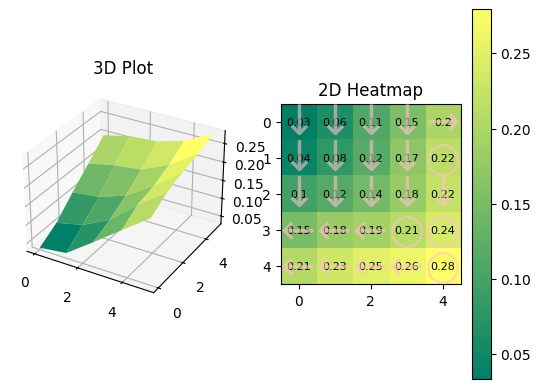

  2%|▏         | 90/5000 [00:00<00:10, 471.82it/s]

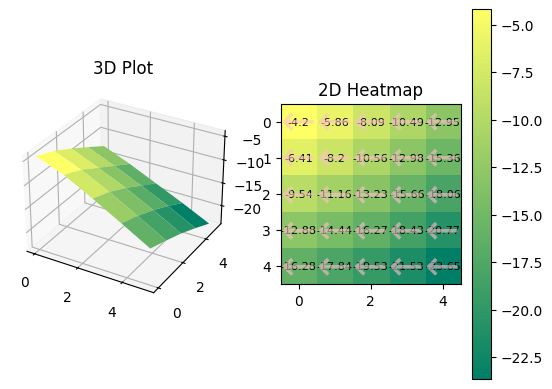

  3%|▎         | 143/5000 [00:00<00:12, 387.37it/s]

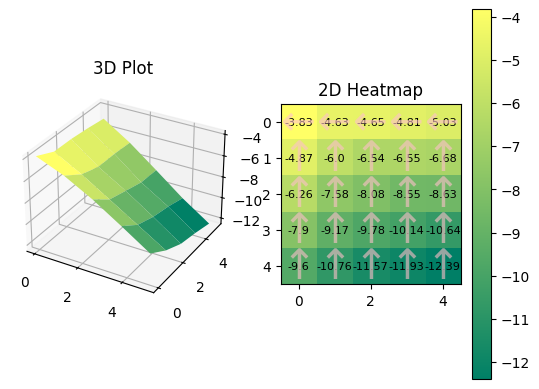

  6%|▌         | 293/5000 [00:00<00:09, 522.33it/s]

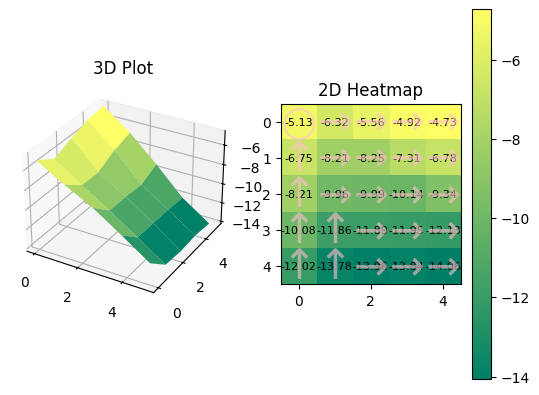

  7%|▋         | 352/5000 [00:00<00:10, 455.70it/s]

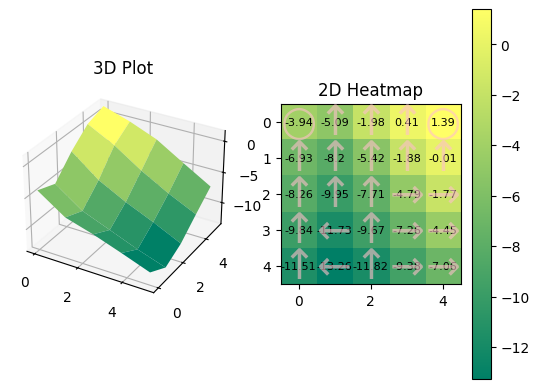

 10%|█         | 500/5000 [00:01<00:09, 496.45it/s]

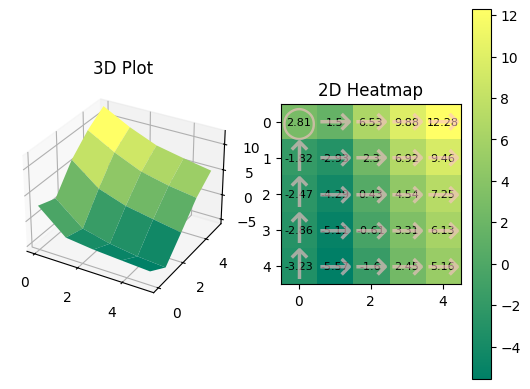

 11%|█         | 560/5000 [00:01<00:09, 447.38it/s]

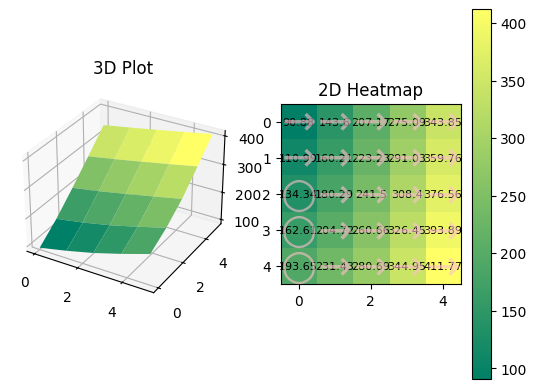

 12%|█▏        | 612/5000 [00:01<00:10, 406.72it/s]

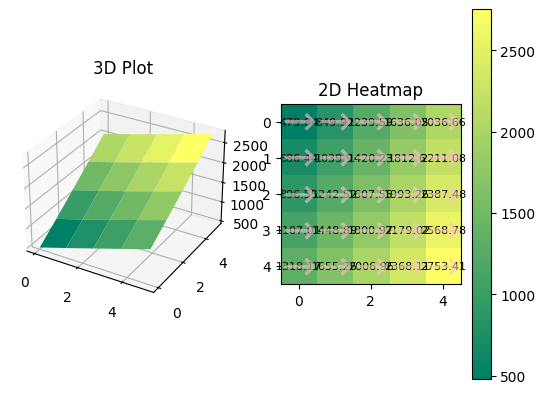

 16%|█▌        | 793/5000 [00:01<00:08, 524.84it/s]

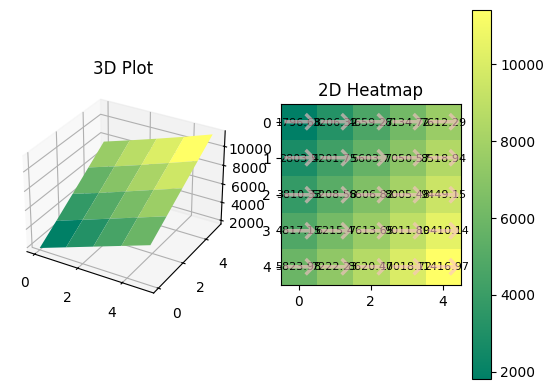

 17%|█▋        | 853/5000 [00:01<00:08, 464.32it/s]

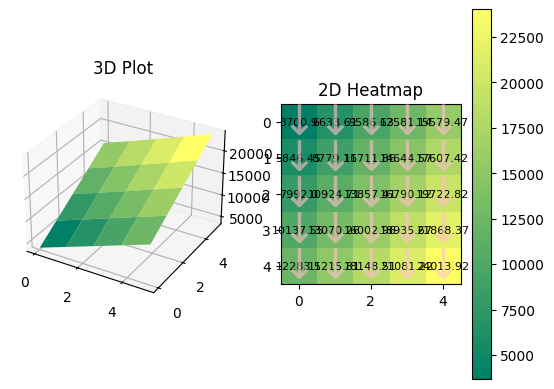

 20%|█▉        | 989/5000 [00:02<00:07, 506.45it/s]

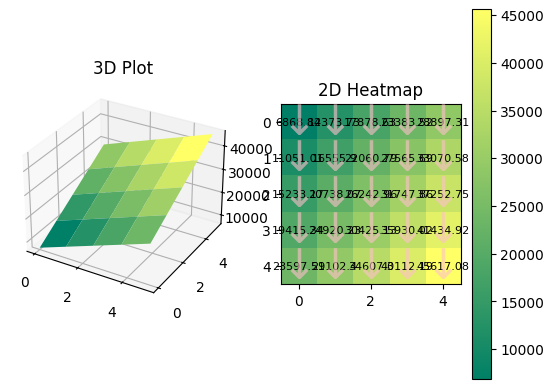

 21%|██        | 1047/5000 [00:02<00:08, 441.89it/s]

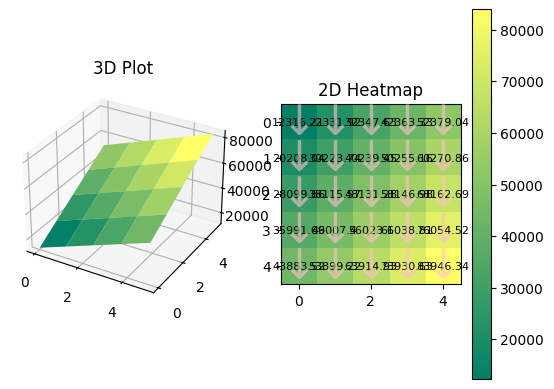

 24%|██▍       | 1196/5000 [00:02<00:07, 523.72it/s]

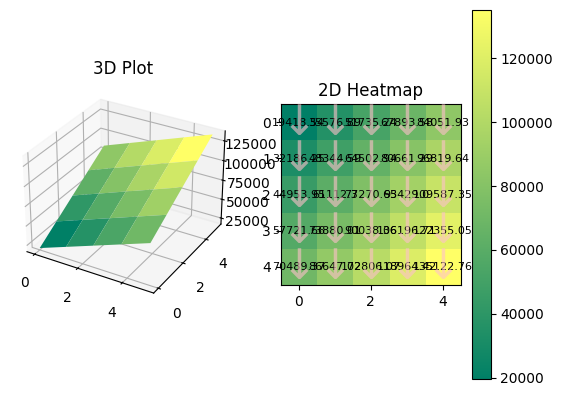

 25%|██▌       | 1256/5000 [00:02<00:09, 408.39it/s]

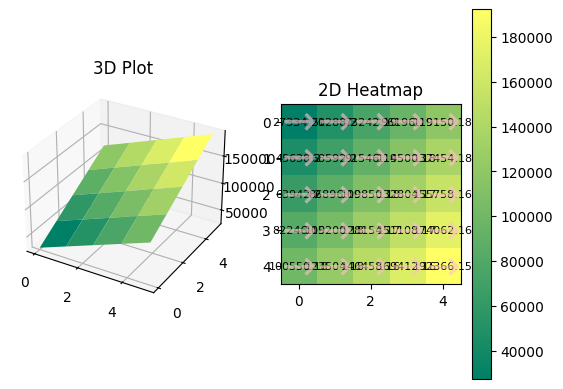

 28%|██▊       | 1395/5000 [00:03<00:07, 480.01it/s]

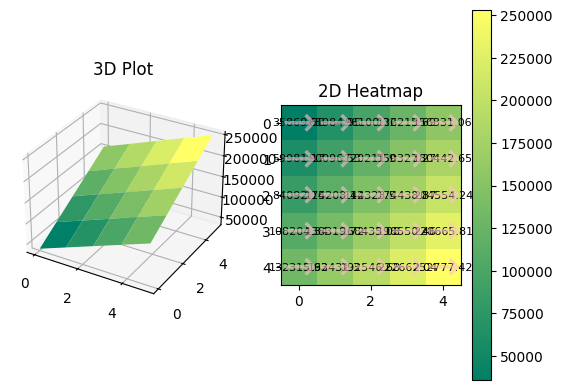

 29%|██▉       | 1453/5000 [00:03<00:08, 427.17it/s]

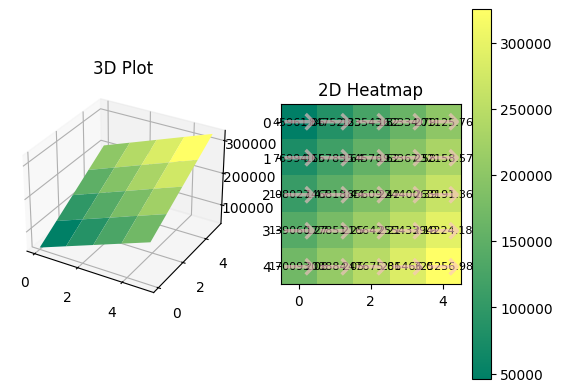

 32%|███▏      | 1594/5000 [00:03<00:06, 502.66it/s]

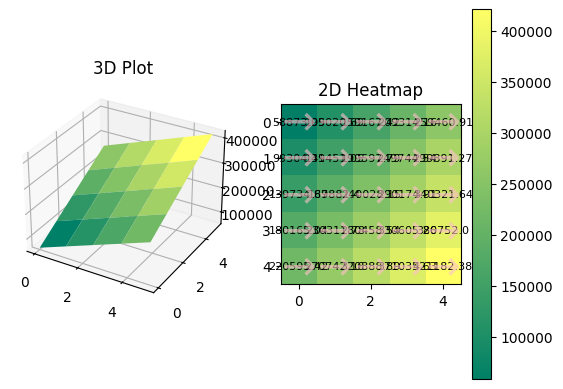

 33%|███▎      | 1653/5000 [00:03<00:07, 445.71it/s]

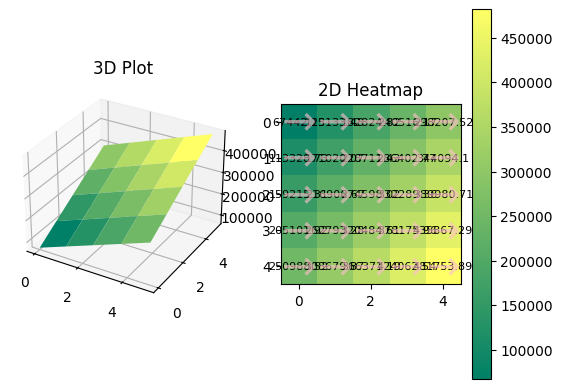

 36%|███▌      | 1796/5000 [00:04<00:06, 515.34it/s]

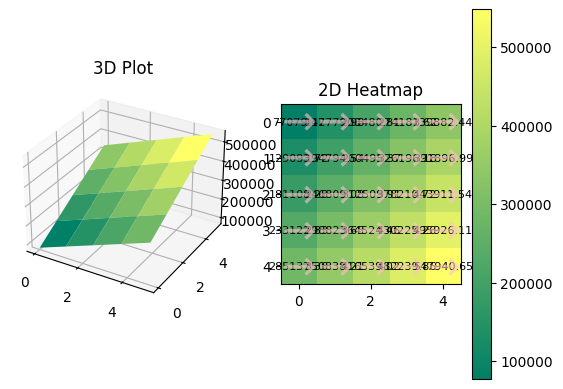

 37%|███▋      | 1855/5000 [00:04<00:06, 450.96it/s]

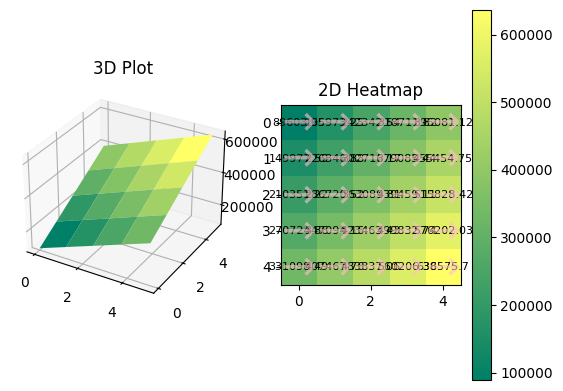

 38%|███▊      | 1907/5000 [00:04<00:08, 362.19it/s]

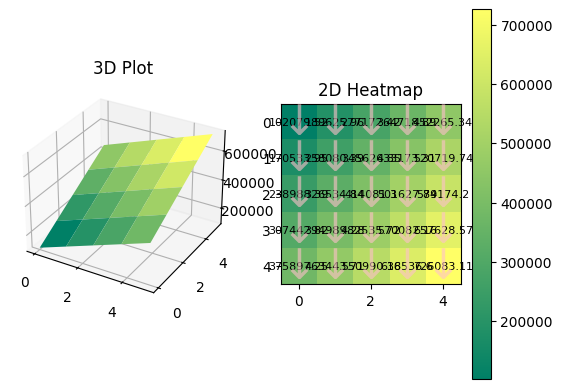

 42%|████▏     | 2091/5000 [00:04<00:05, 488.83it/s]

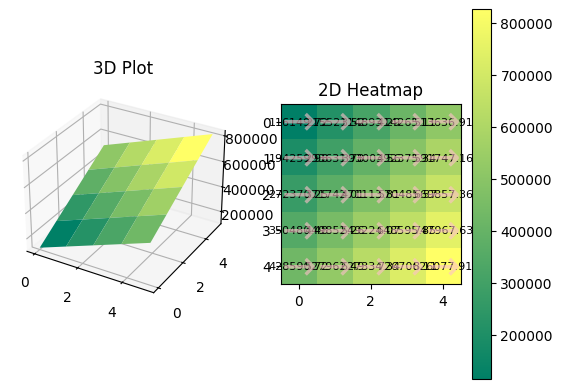

 43%|████▎     | 2149/5000 [00:04<00:06, 439.23it/s]

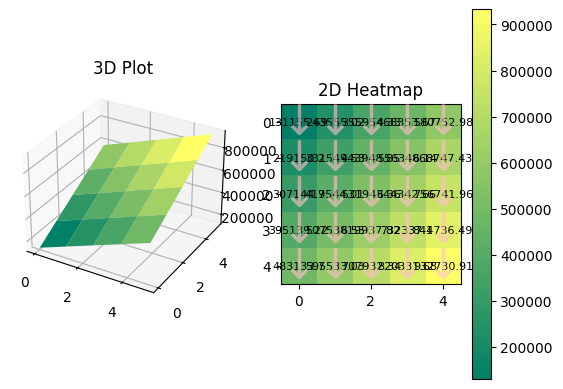

 46%|████▌     | 2288/5000 [00:05<00:05, 497.90it/s]

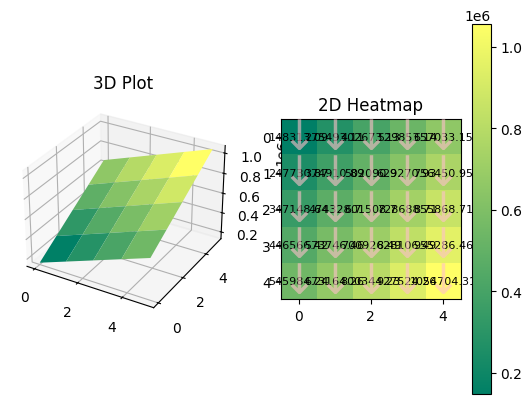

 47%|████▋     | 2346/5000 [00:05<00:06, 438.93it/s]

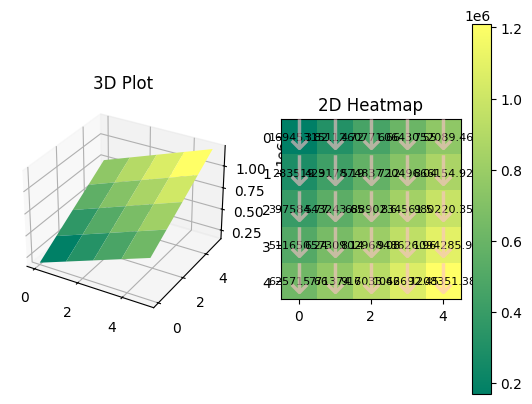

 50%|████▉     | 2493/5000 [00:05<00:04, 514.32it/s]

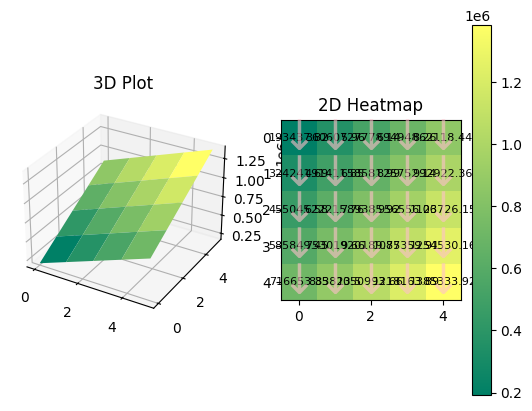

 51%|█████     | 2552/5000 [00:05<00:05, 448.75it/s]

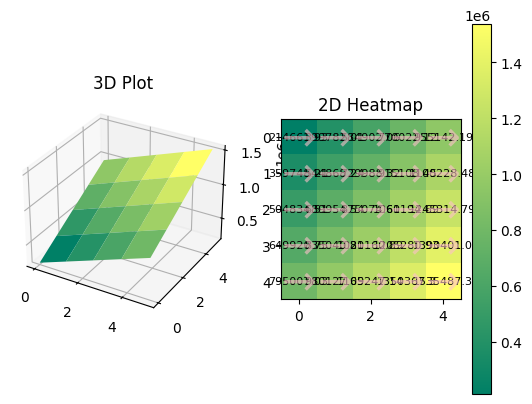

 54%|█████▍    | 2695/5000 [00:06<00:04, 467.89it/s]

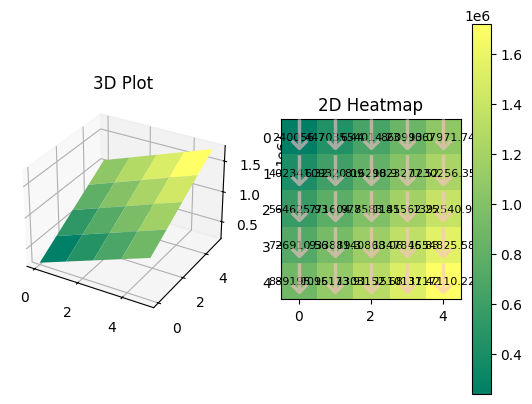

 55%|█████▌    | 2753/5000 [00:06<00:05, 424.96it/s]

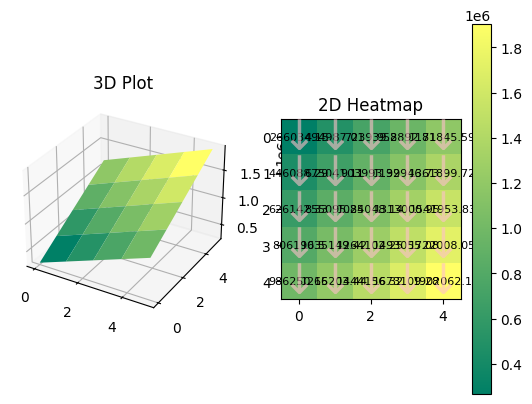

 58%|█████▊    | 2892/5000 [00:06<00:04, 490.54it/s]

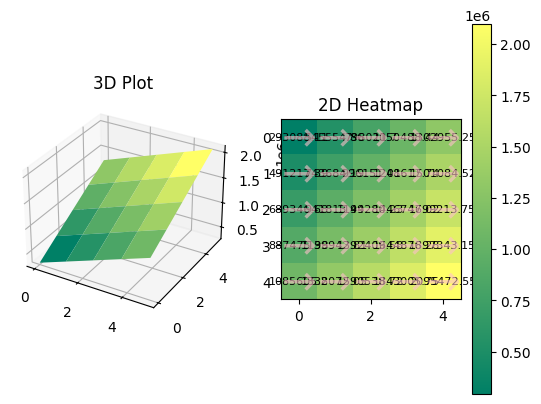

 59%|█████▉    | 2950/5000 [00:06<00:04, 435.25it/s]

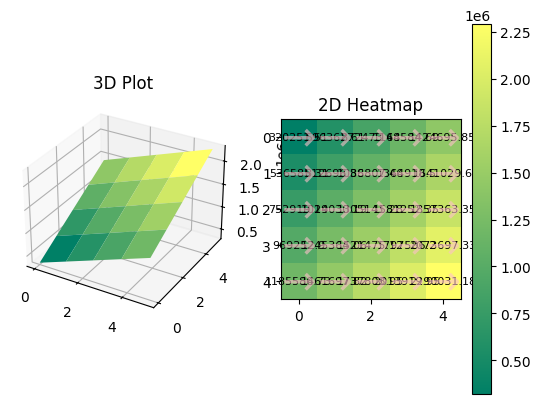

 62%|██████▏   | 3093/5000 [00:07<00:03, 510.47it/s]

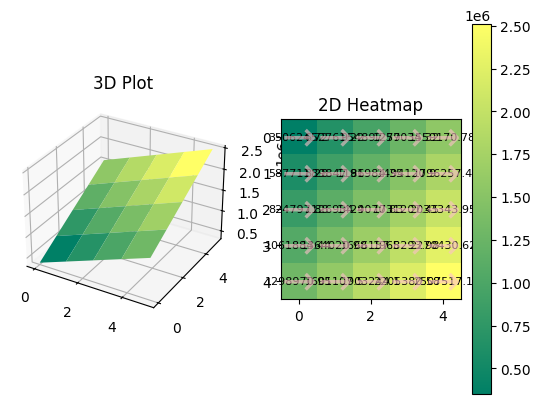

 63%|██████▎   | 3152/5000 [00:07<00:04, 447.63it/s]

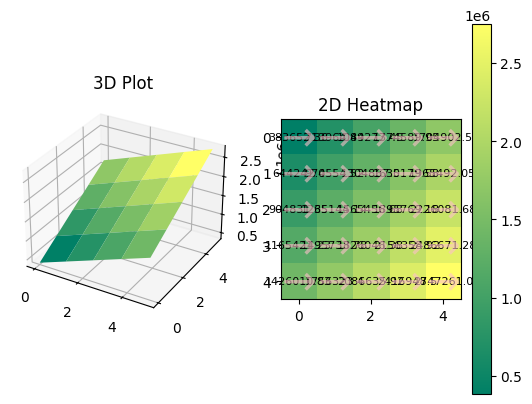

 66%|██████▌   | 3297/5000 [00:07<00:03, 517.21it/s]

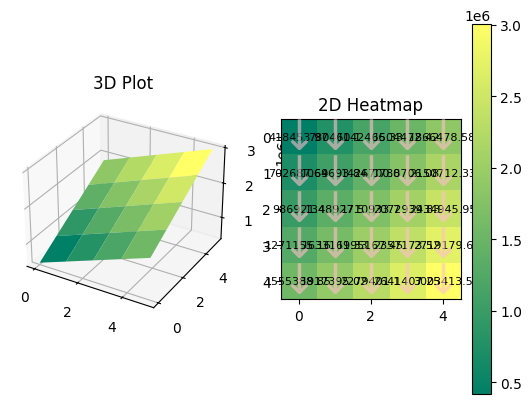

 67%|██████▋   | 3357/5000 [00:07<00:04, 393.16it/s]

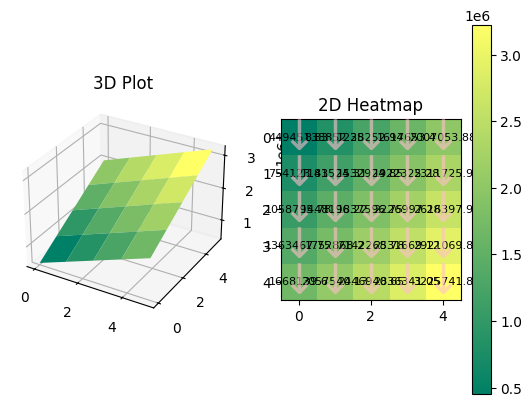

 68%|██████▊   | 3406/5000 [00:07<00:04, 365.64it/s]

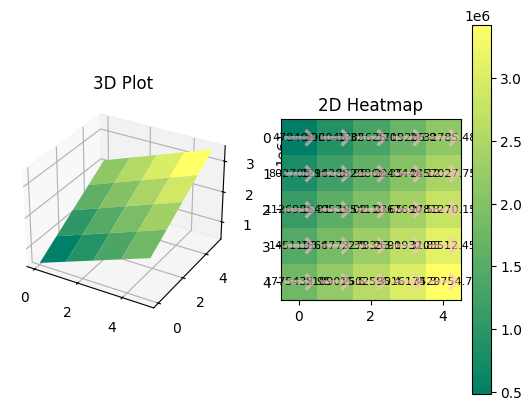

 72%|███████▏  | 3591/5000 [00:08<00:02, 492.98it/s]

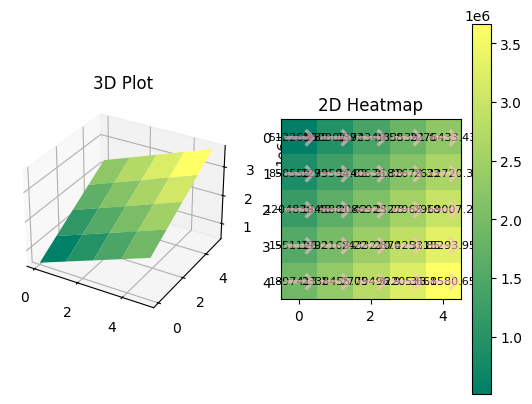

 73%|███████▎  | 3649/5000 [00:08<00:03, 444.95it/s]

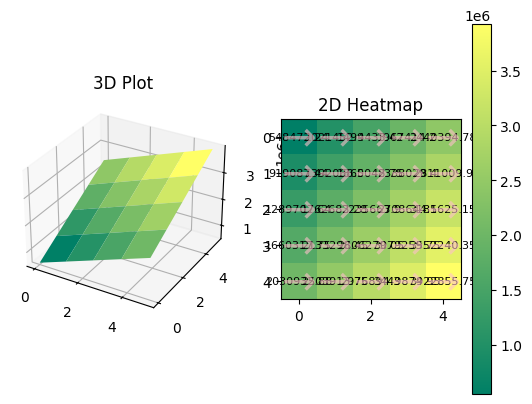

 76%|███████▌  | 3791/5000 [00:08<00:02, 511.87it/s]

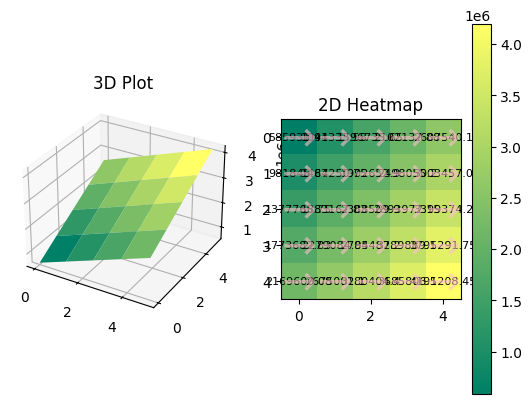

 77%|███████▋  | 3850/5000 [00:08<00:02, 452.25it/s]

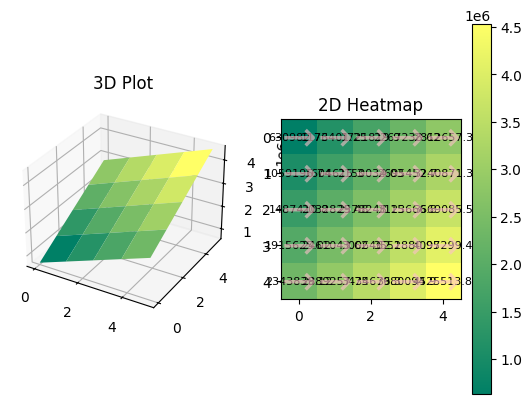

 80%|███████▉  | 3994/5000 [00:09<00:01, 518.70it/s]

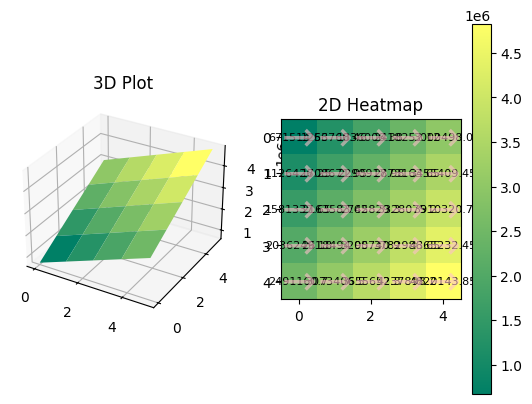

 81%|████████  | 4054/5000 [00:09<00:02, 387.77it/s]

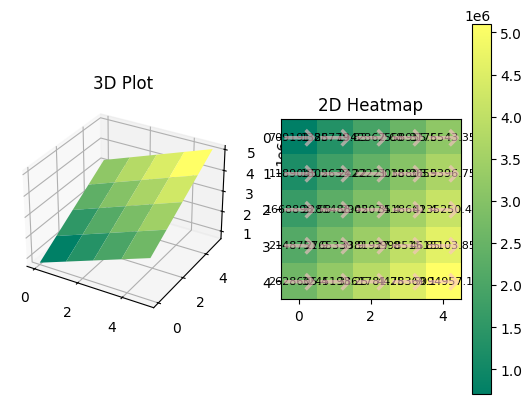

 84%|████████▍ | 4199/5000 [00:09<00:01, 481.81it/s]

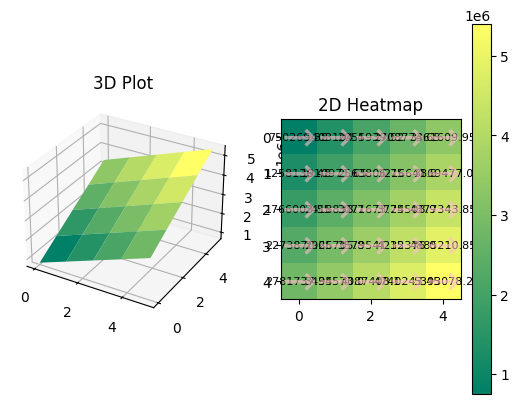

 85%|████████▌ | 4258/5000 [00:09<00:01, 433.35it/s]

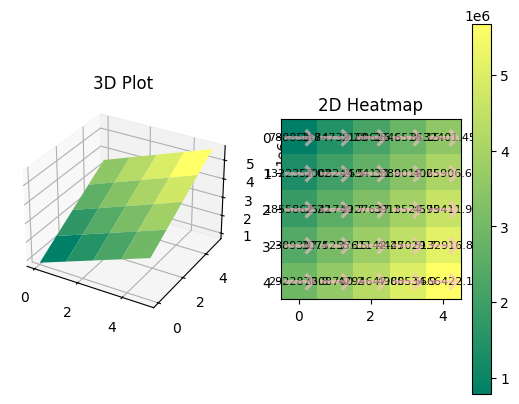

 88%|████████▊ | 4389/5000 [00:10<00:01, 478.45it/s]

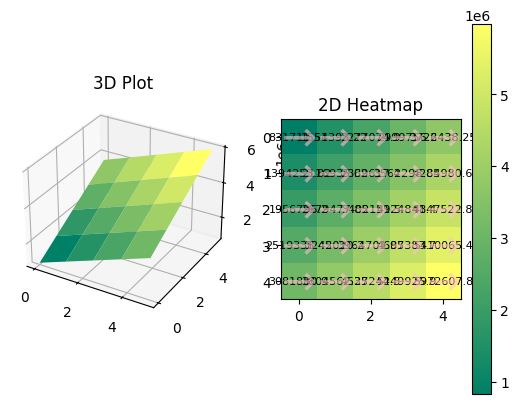

 89%|████████▉ | 4444/5000 [00:10<00:01, 425.53it/s]

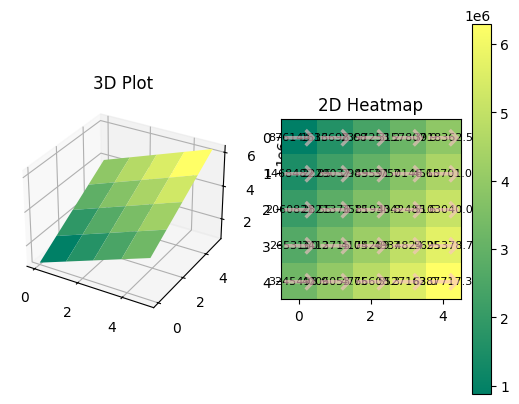

 92%|█████████▏| 4589/5000 [00:10<00:00, 497.68it/s]

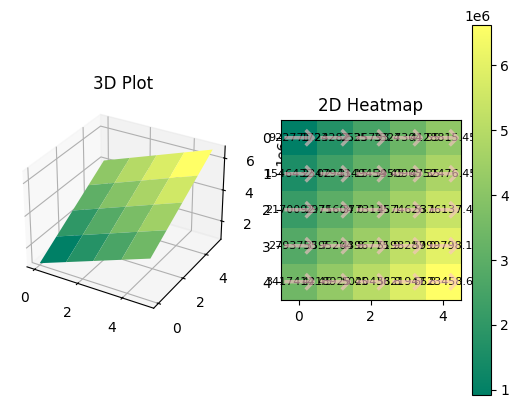

 93%|█████████▎| 4646/5000 [00:10<00:00, 441.59it/s]

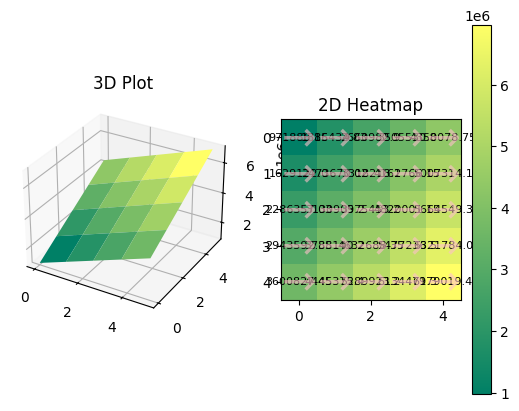

 96%|█████████▌| 4794/5000 [00:10<00:00, 519.11it/s]

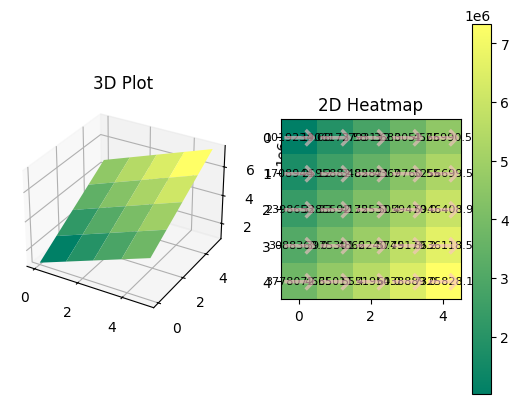

 97%|█████████▋| 4854/5000 [00:11<00:00, 396.14it/s]

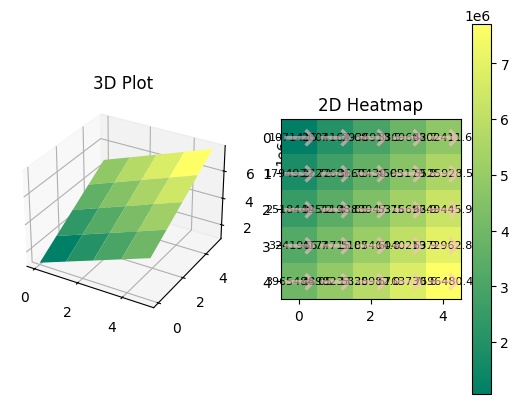

100%|██████████| 5000/5000 [00:11<00:00, 437.50it/s]


In [16]:
# 循环 5000 次，使用 tqdm 库显示进度条
for _ in tqdm.tqdm(range(5000)):
    
    # 清空优化器中的梯度信息，防止梯度累积
    optimizer.zero_grad()
    
    # 从经验池 experiencePool 中随机采样一个批次的数据
    batch = experiencePool.sample_batch(batch_size=batch_size)
    # 解包采样得到的数据，分别为当前状态、当前动作、当前得分、下一个状态、下一个动作和是否终止标志
    tmpstate, tmpaction, tmpscore, nextState, nextAction, terminal = batch

    # 将当前状态数据重塑为 (batch_size, 1) 的形状
    tmpstate = tmpstate.reshape(batch_size,1)
    # 将当前状态转换为行列表示，方便后续处理
    tmpstate = np.hstack((tmpstate // 5, tmpstate % 5))  
    # 将下一个状态数据重塑为 (batch_size, 1) 的形状
    nextState = nextState.reshape(batch_size,1)
    # 将下一个状态转换为行列表示，方便后续处理
    nextState = np.hstack((nextState // 5, nextState % 5))  

    # 将当前状态转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 2)
    tmpstate = torch.tensor(tmpstate,dtype = torch.float32).view(batch_size,2)
    # 将下一个状态转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 2)
    nextState = torch.tensor(nextState,dtype = torch.float32).view(batch_size,2)

    # 注释掉的代码，原本用于将当前动作和下一个动作转换为 PyTorch 张量
    # tmpaction = torch.tensor(tmpaction,dtype = torch.int).view(batch_size,1)
    # nextAction = torch.tensor(nextAction,dtype = torch.int).view(batch_size,1)

    # 将当前得分转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 1)
    tmpscore = torch.tensor(tmpscore,dtype = torch.float32).view(batch_size,1)
    # 将是否终止标志转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (batch_size, 1)
    terminal = torch.tensor(terminal,dtype = torch.float32).view(batch_size,1)

    # 上下文管理器，不计算梯度，提高计算效率
    with torch.no_grad():
        # 输入下一个状态到神经网络，计算下一个状态的所有动作值
        next_action_values = network(nextState)  #网络
        
        # 从下一个状态的所有动作值中，选取下一个实际执行动作对应的动作值
        # b = [next_action_values[i,nextAction[i]] for i in range(batch_size)]
        # # 将选取的动作值转换为 PyTorch 张量，并调整形状为 (batch_size, 1)
        # next_action_value = torch.tensor(b,dtype = torch.float32).view(batch_size,1)
        
        # 注释掉的代码，原本用于选取下一个状态的所有动作值中的最大值，适用于 DQN
        c = next_action_values.max(1)[0] #改成DQN了，这里就得取最大值
        next_action_value = torch.tensor(c,dtype = torch.float32).view(batch_size,1)
        
        # 根据贝尔曼方程计算目标值
        target = tmpscore + (1.0 - terminal) * gamma * next_action_value

    # 输入当前状态到神经网络，计算当前状态的所有动作值
    now_action_values = network(tmpstate)    #网络
    
    # 选取当前状态下第一个样本的实际执行动作对应的动作值
    now_action_value = now_action_values[0,tmpaction[0]]
    
    # 遍历剩余的样本，依次选取实际执行动作对应的动作值，并拼接在一起
    for i in range(1,batch_size):
        now_action_value = torch.cat((now_action_value.view(-1), now_action_values[i,tmpaction[i]].view(-1)),dim=0)
    
    # 调整当前动作值的形状为 (batch_size, 1)
    now_action_value = now_action_value.view(-1,1)
    
    # 计算当前动作值和目标值之间的均方误差损失
    loss = F.mse_loss(now_action_value, target)
    # 反向传播计算梯度
    loss.backward()
    # 优化器根据计算得到的梯度更新神经网络的参数
    optimizer.step()
            
    # 每 100 次迭代执行一次以下操作
    if _ % 100 == 0:
        # 生成从 0 到 24 的状态数组
        s = np.array([[i] for i in range(25)])
        # 将状态数组转换为行列表示
        s = np.hstack((s // 5, s % 5))
        # 将状态数组转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (25, 2)
        states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # 注释掉的代码，原本用于将神经网络输出转换为状态值并转换为 numpy 数组
        # 还原成state_values
        # state_values = network(states).view(-1).detach().numpy()
        
        # 生成从 0 到 24 的状态数组
        s = np.array([[i] for i in range(25)])
        # 将状态数组转换为行列表示
        s = np.hstack((s // 5, s % 5))
        # 将状态数组转换为 PyTorch 张量，数据类型为 float32，并调整形状为 (25, 2)
        states = torch.tensor(s, dtype = torch.float32).view(25,2)
        # 将神经网络输出转换为动作值并转换为 numpy 数组
        action_values = network(states).view(-1,5).detach().numpy()

        # 根据策略和动作值计算状态值
        state_values = np.sum(policy * action_values,axis=1)

        # 选取每个状态下动作值最大的动作索引
        p = np.argmax(action_values,axis=1)
        # 调用 draw 函数绘制状态值和最优动作
        draw(state_values.reshape(5,5), p)